# Analysis of Spatial Invariance in Convolutional Neural Networks

1.	Does data augmentation lead to more spatially invariant and robust networks?
2.	Are deep architectures more spatially invariant than wide architectures? Did a particular architecture perform better?
3.	Does generative data augmentation lead to more diverse samples than reinforcement learning techniques? Policy 2 vs. Policy 3.
4.	Do larger datasets increase spatial invariance? (Policy 2,4,5 vs. Policy 1 and 3)
5.	Do stacking data augmentation methods lead to more robust networks? Policy 5.
6.	Does combining synthesized samples with original unaugmented samples improve invariance in CNNs? Policy 4
7.	Do synthesized samples improve invariance? Policy 3
8.	Do Stochastic techniques based on Reinforcement learning techniques improve invariance? Policy 2
9.	Does the number of parameters in a CNN affect its spatial invariance as measured by its test accuracy?


# Imports

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import datetime
import os

# Hyperparameters

In [265]:
DATASET = "FMNIST" # "CIFAR10", "MNIST", "FMNIST
NETWORK = "resnet"  # "resnet", "inception"
FOLDER = "." + os.sep + DATASET + os.sep + NETWORK
HISTORY_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_history.csv'
METRICS_FILE = FOLDER + os.sep + f'{DATASET}_{NETWORK}_metrics.csv'
NUMBER_POLICIES = 5
NETWORK_TITLE = "ResNet-50" if NETWORK == "resnet" else "InceptionV3"

In [266]:
assert DATASET in ["CIFAR10", "MNIST", "FMNIST"], "DATASET must be CIFAR10, MNIST or FMNIST"
assert NETWORK in ["resnet", "inception"], "NETWORK must be resnet or inception"

# Load history and metrics

#### History summary

In [267]:
history = pd.read_csv(HISTORY_FILE)
print("Total records:", len(history))
history.head()

Total records: 257


,loss,accuracy,val_loss,val_accuracy,lr,policy
0,0.546432,0.816889,0.736655,0.758500,0.0003,1
1,0.224415,0.917796,0.385617,0.881000,0.0003,1
2,0.164856,0.939056,0.259485,0.905333,0.0003,1
3,0.132756,0.950630,0.333230,0.886000,0.0003,1
4,0.109619,0.960074,0.271050,0.908833,0.0003,1


#### Metrics summary

In [268]:
metrics = pd.read_csv(METRICS_FILE)
print("Total records:", len(metrics))
metrics.head()

Total records: 5


,dataset,model,params,policy,accuracy,precision,recall,f1score,latency
0,fmnist,resnet,23585290,1,0.8985,0.900156,0.8985,0.896763,752.516647
1,fmnist,resnet,23585290,2,0.9266,0.927923,0.9266,0.926928,1300.342571
2,fmnist,resnet,23585290,3,0.8267,0.828947,0.8267,0.820631,690.769417
3,fmnist,resnet,23585290,4,0.9159,0.917034,0.9159,0.916216,1587.408635
4,fmnist,resnet,23585290,5,0.8500,0.858215,0.8500,0.851751,970.132853


#### Extract and plot policy histories

In [269]:
# Extract the history for each policy
policies = []
for i in range(1, NUMBER_POLICIES + 1):
    policies.append(history[history['policy'] == i])

In [270]:
def plot_history(history, policy_num):
    epochs = range(1, len(history.loss) + 1)
    # plot loss during training
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Policy {policy_num} for {DATASET} on {NETWORK_TITLE}")
    ax1.set_title("Training Loss", fontsize=10)
    ax1.plot(epochs, history.loss, "--")
    ax1.plot(epochs, history.val_loss, "--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(["training", "validation"], loc="best")
    # plot accuracy during training
    ax2.set_title("Training Accuracy", fontsize=10)
    ax2.plot(epochs, history.accuracy, "--")
    ax2.plot(epochs, history.val_accuracy, "--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["training", "validation"], loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + f"/{DATASET}_{NETWORK}_policy{policy_num}_plot.png")
    plt.show()
    plt.close()

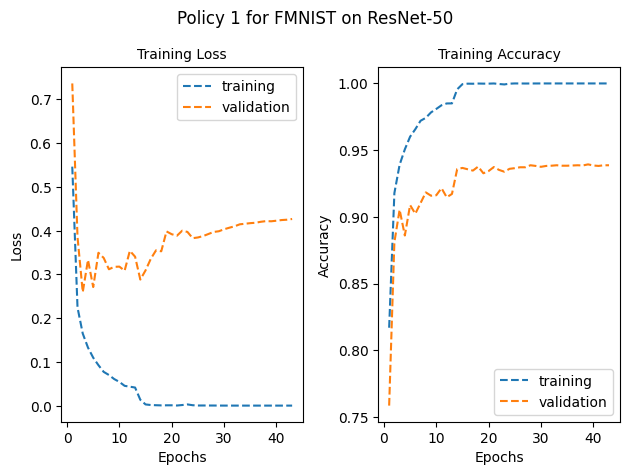

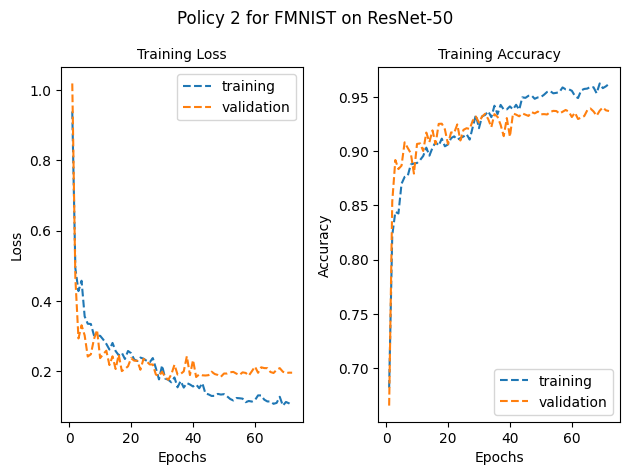

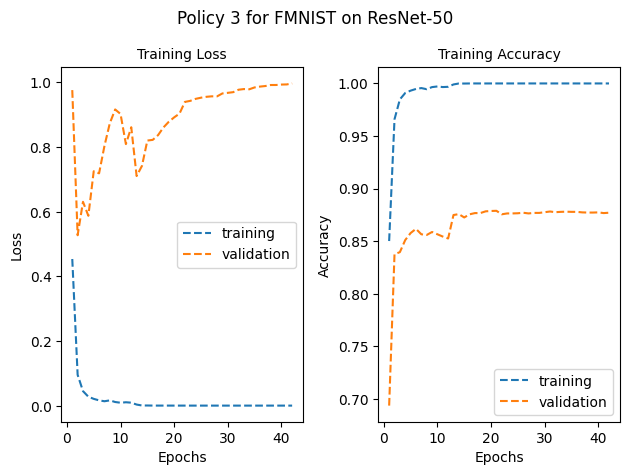

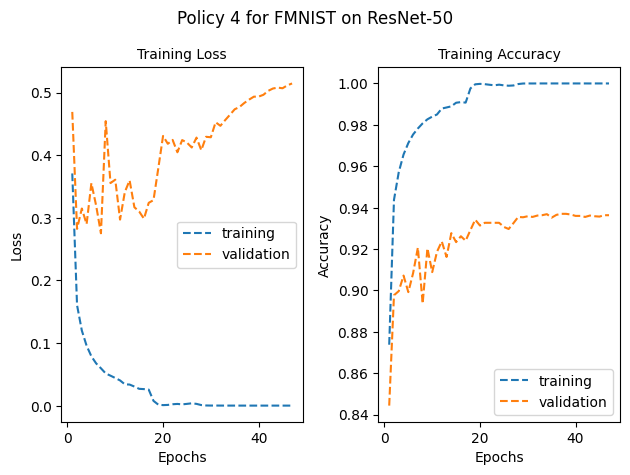

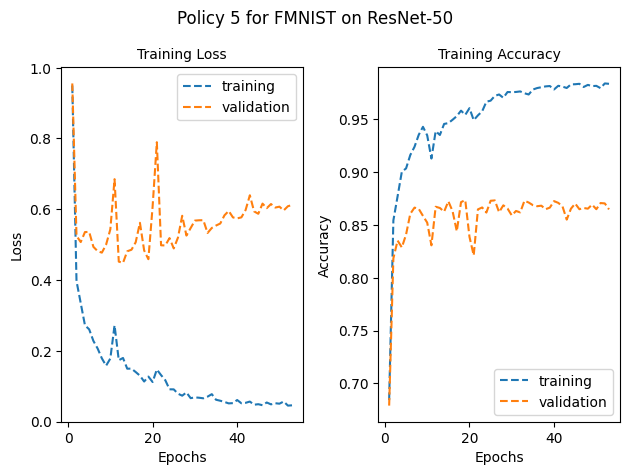

In [271]:
# Plot the history for each policy
for i, p in enumerate(policies):
    plot_history(p, i+1)

In [272]:
def plot_all_policies(policies,val=False,train=False):
    epochs = range(1, len(policies[0].loss) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
    fig.suptitle(f"All policies for {DATASET} on {NETWORK_TITLE}")
    ax1.set_title("Training Loss", fontsize=10)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_title("Training Accuracy", fontsize=10)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    for i, p in enumerate(policies):
        epochs = range(1, len(p.loss) + 1)
        if train:
            ax1.plot(epochs, p.loss, "--", label=f"policy {i+1}")
            ax2.plot(epochs, p.accuracy, "--", label=f"policy {i+1}")
        elif val:
            ax1.set_title("Validation Loss", fontsize=10)
            ax2.set_title("Validation Accuracy", fontsize=10)
            ax1.plot(epochs, p.val_loss, "--", label=f"policy {i+1}")
            ax2.plot(epochs, p.val_accuracy, "--", label=f"policy {i+1}")
        else:
            ax1.set_title("Training & Validation Loss", fontsize=10)
            ax1.plot(epochs, p.loss, "--", label=f"policy {i+1} (loss)")
            ax1.plot(epochs, p.val_loss, label=f"policy {i+1} (val_loss)")
            ax2.set_title("Training & Validation Accuracy", fontsize=10)
            ax2.plot(epochs, p.accuracy, "--", label=f"policy {i+1} (acc)")
            ax2.plot(epochs, p.val_accuracy, label=f"policy {i+1} (val_acc)")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    plt.tight_layout()
    plt.savefig(FOLDER + "/{}_{}_all_policies_plot.png".format(DATASET, NETWORK))
    plt.show()
    plt.close()

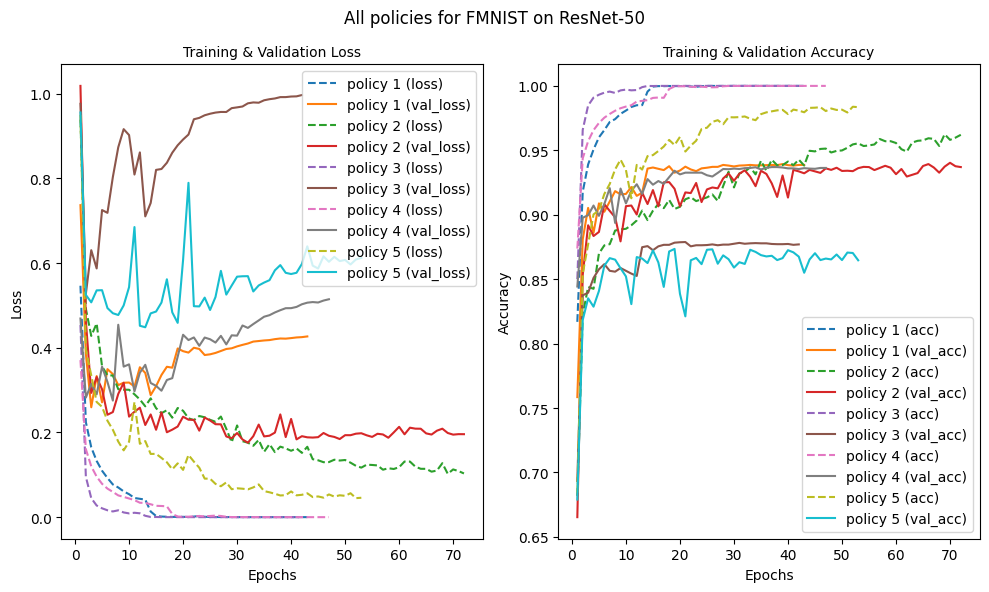

In [273]:
# plot history for all policies
plot_all_policies(policies)


#### Training latency

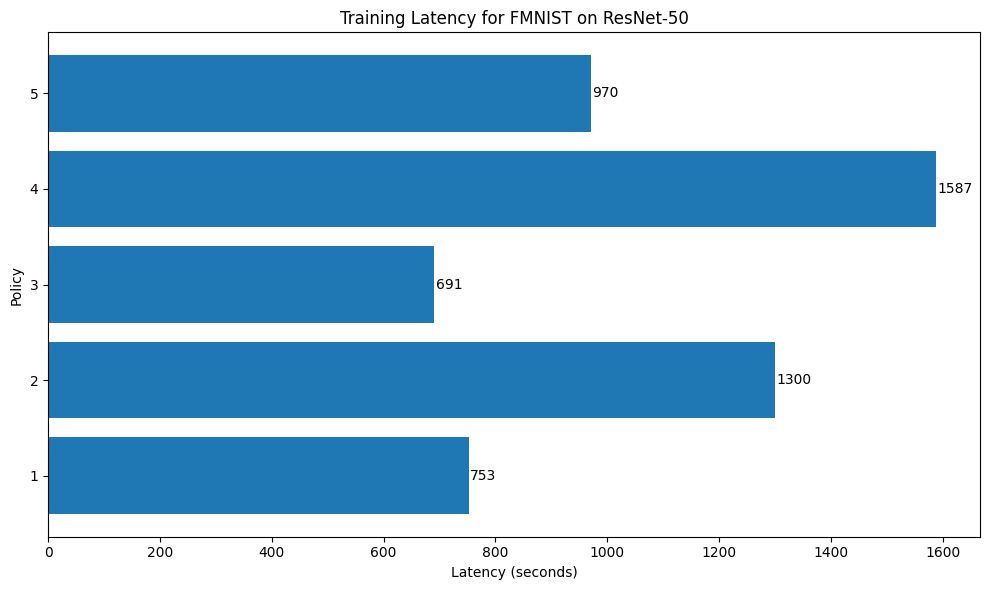

In [274]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(metrics.policy, metrics.latency)
ax.bar_label(bars, fmt="%.0f", padding=1)
ax.set_title(f"Training Latency for {DATASET} on {NETWORK_TITLE}")
ax.set_xlabel("Latency (seconds)")
ax.set_ylabel("Policy")
plt.tight_layout()
plt.show()

#### Show total latency for all policies

In [312]:
h, m, s = str(datetime.timedelta(seconds=metrics.latency.sum())).split(':')
print(f'{h} hours, {m} minutes and {s} seconds')

1 hours, 28 minutes and 21.170123 seconds


#### Test Accuracy

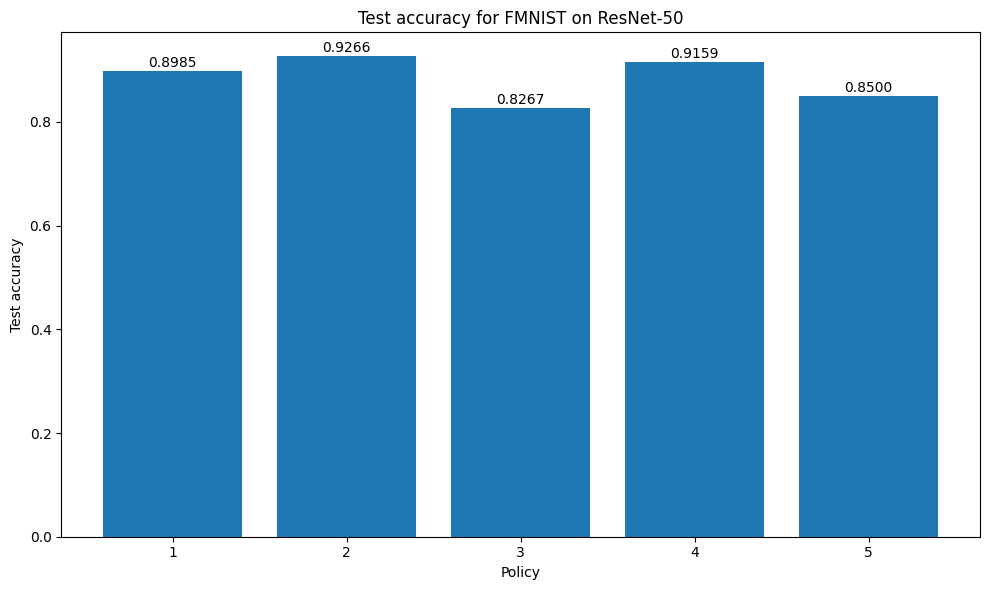

In [275]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics.policy, metrics.accuracy)
ax.bar_label(bars, fmt="%.4f", padding=1)
ax.set_title(f"Test accuracy for {DATASET} on {NETWORK_TITLE}")
ax.set_xlabel("Policy")
ax.set_ylabel("Test accuracy")
plt.tight_layout()
plt.show()

#### F-1 Score

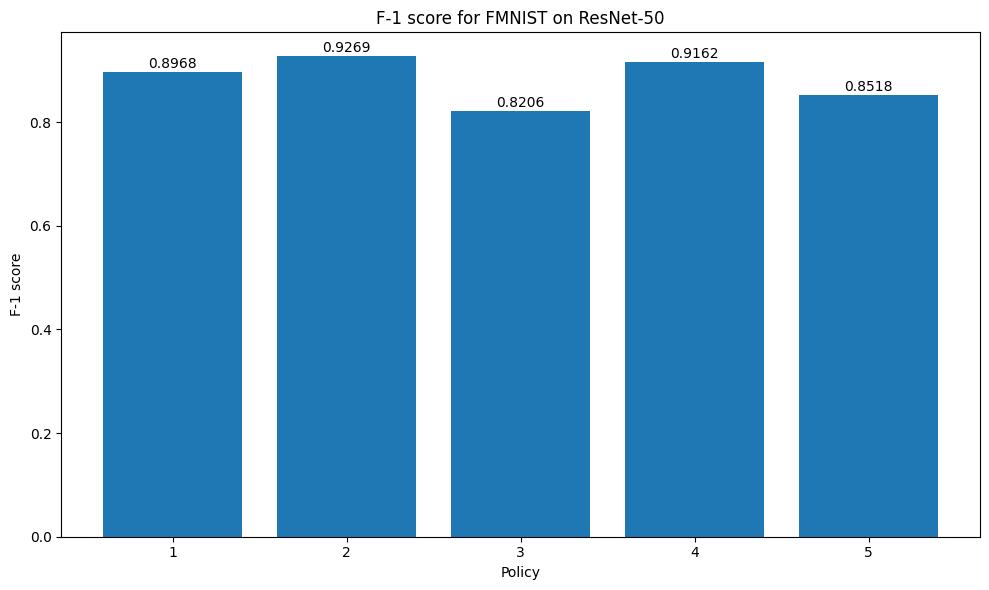

In [276]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics.policy, metrics.f1score)
ax.bar_label(bars, fmt="%.4f", padding=1)
ax.set_title(f"F-1 score for {DATASET} on {NETWORK_TITLE}")
ax.set_xlabel("Policy")
ax.set_ylabel("F-1 score")
plt.tight_layout()
plt.show()

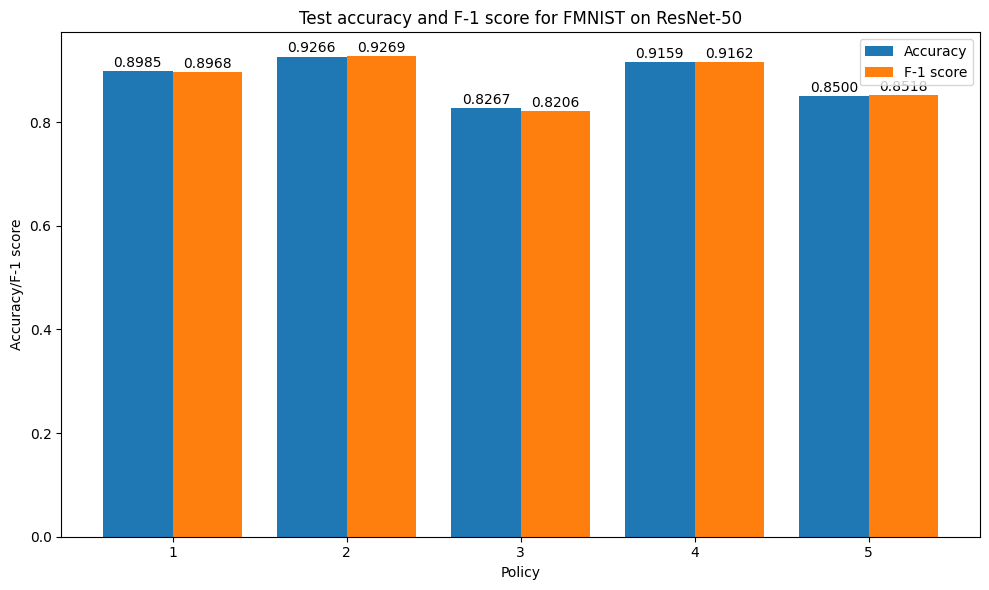

In [313]:
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(metrics.policy - 0.2, metrics.accuracy, 0.4, label = 'Accuracy')
bar2 = ax.bar(metrics.policy + 0.2, metrics.f1score, 0.4, label = 'F-1 score')
#ax.bar_label(bar1, fmt="%.4f", padding=1,label_type='center')
ax.bar_label(bar1, fmt="%.4f", padding=1)
ax.bar_label(bar2, fmt="%.4f", padding=1)
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy/F-1 score")
ax.set_title(f"Test accuracy and F-1 score for {DATASET} on {NETWORK_TITLE}")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

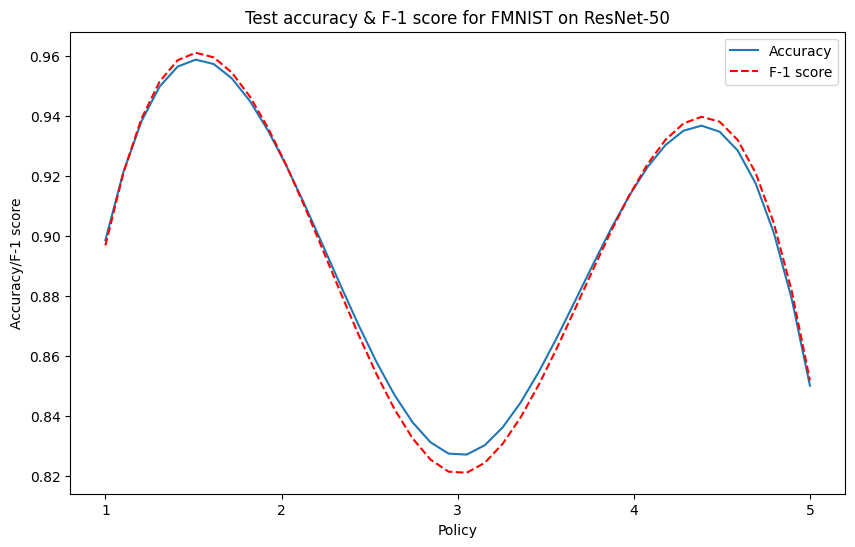

In [278]:
acc_spline = make_interp_spline(metrics.policy, metrics.accuracy)
f1_spline = make_interp_spline(metrics.policy, metrics.f1score)
X = np.linspace(metrics.policy.min(), metrics.policy.max(), 40)
Y1 = acc_spline(X)
Y2 = f1_spline(X)

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the Graph
ax.plot(X, Y1, label="Accuracy")
ax.plot(X, Y2,"r--", label="F-1 score")
ax.set_title("Test accuracy & F-1 score for {} on {}".format(DATASET, NETWORK_TITLE))
ax.set_xlabel("Policy")
ax.set_ylabel("Accuracy/F-1 score")
ax.legend(loc="best")
ax.set_xticks(metrics.policy)
plt.show()
